# **Modelling and Evaluation**

## Objectives

* Fit and evaluate a regression model to predict sale price based on house attributes.

## Inputs

* outputs/datasets/collection/house_prices_records.csv 

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict sale price
* Feature importance plot


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/PP5-heritage-housing'

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
print(df.shape)
df.head()

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# ML Pipeline: Regressor

### Create the ML Pipeline

In [5]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF','MasVnrArea'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),
                                 
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling - Standardize features by removing the mean and scaling to unit variance.
        ("scaler", StandardScaler()),

        # Feature Selection - Meta-transformer for selecting features based on importance weights.
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for hyperparamter optimization taken from CI Churnometer Walkthrough Project.

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

### Split Train and Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


### Grid Search CV - Sklearn

Use standard hyperparameters to find most suitable algorithm

In [8]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimization search using default hyperparameters.

In [9]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Check results

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.684431,0.777866,0.821982,0.049057
3,ExtraTreesRegressor,0.647203,0.764593,0.814631,0.059854
5,GradientBoostingRegressor,0.594485,0.757439,0.833795,0.084639
0,LinearRegression,0.630531,0.719183,0.746406,0.044514
6,XGBRegressor,0.668421,0.717269,0.797614,0.047113
4,AdaBoostRegressor,0.507364,0.645852,0.741273,0.110291
1,DecisionTreeRegressor,0.434299,0.517566,0.646729,0.070271


In [11]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'RandomForestRegressor'

This first quick assessment suggests 'RandomForestRegressor' as the most appropriate regression algorithms followed by 'ExtraTreesRegressor' and 'GradientBoostingRegressor' which could also be used for further investigation.

### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

The following model and hyperparameters were selected as being the best balance between performance for generalisation on unseen data whilst minimising potential for overfitting.

In [18]:
# These hyperparameter configurations were obtained from Code Institute Scikit-Learn Unit 6:
# documentation to help on hyperparameter:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),    
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                           'model__max_depth': [None, 3, 15],
                           'model__min_samples_split': [2, 50],
                           'model__min_samples_leaf': [1,50],
    },  

    "RandomForestRegressor":{'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
    },
    
    "GradientBoostingRegressor":{'model__n_estimators': [100,50,140],
                                 'model__learning_rate':[0.1, 0.01, 0.001],
                                 'model__max_depth': [3,15, None],
                                 'model__min_samples_split': [2,50],
                                 'model__min_samples_leaf': [1,50],
                                 'model__max_leaf_nodes': [None,50],
    }
}

In [19]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [20]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__max_leaf_nodes,model__learning_rate
38,RandomForestRegressor,0.688624,0.778326,0.821522,0.04741,None,1,2,140,None,NaN
86,RandomForestRegressor,0.69052,0.778261,0.821927,0.046647,15,1,2,140,None,NaN
84,RandomForestRegressor,0.690005,0.778257,0.823249,0.047149,15,1,2,100,None,NaN
36,RandomForestRegressor,0.684431,0.777866,0.821982,0.049057,None,1,2,100,None,NaN
119,GradientBoostingRegressor,0.707366,0.775497,0.820881,0.043172,3,50,50,140,None,0.1
...,...,...,...,...,...,...,...,...,...,...,...
265,GradientBoostingRegressor,0.026313,0.048634,0.061604,0.011795,3,1,2,50,50,0.001
259,GradientBoostingRegressor,0.028956,0.047507,0.061443,0.010832,3,50,2,50,None,0.001
262,GradientBoostingRegressor,0.028956,0.047507,0.061443,0.010832,3,50,50,50,None,0.001
271,GradientBoostingRegressor,0.028956,0.047507,0.061443,0.010832,3,50,2,50,50,0.001


In [21]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'RandomForestRegressor'

In [22]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

In [23]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageYrBlt'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImp...
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GrLivArea', 'KitchenQual',
                                                     'LotArea', 'LotFrontage',
                                     

### Assess feature importance

The original Data Set was reduced from 24 to 18 variables through the last 2 notebooks (Data Cleaning and Future Engineering). As we now have defined  ExtraTreesRegressor as the best model with the best parameters, we need to get the features that are the most relevant and display on a bar plot.

* These are the 5 most important features in descending order. The model was trained on them: 
['GarageArea', 'YearBuilt', 'TotalBsmtSF', '2ndFlrSF', 'LotArea']


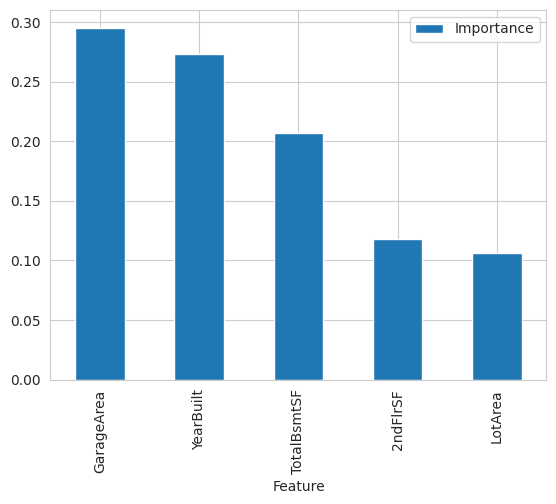

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 9 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate on Train and Test Sets

In [28]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.97
Mean Absolute Error: 8703.367
Mean Squared Error: 187086441.62
Root Mean Squared Error: 13677.955


* Test Set
R2 Score: 0.769
Mean Absolute Error: 25403.782
Mean Squared Error: 1596215574.465
Root Mean Squared Error: 39952.667




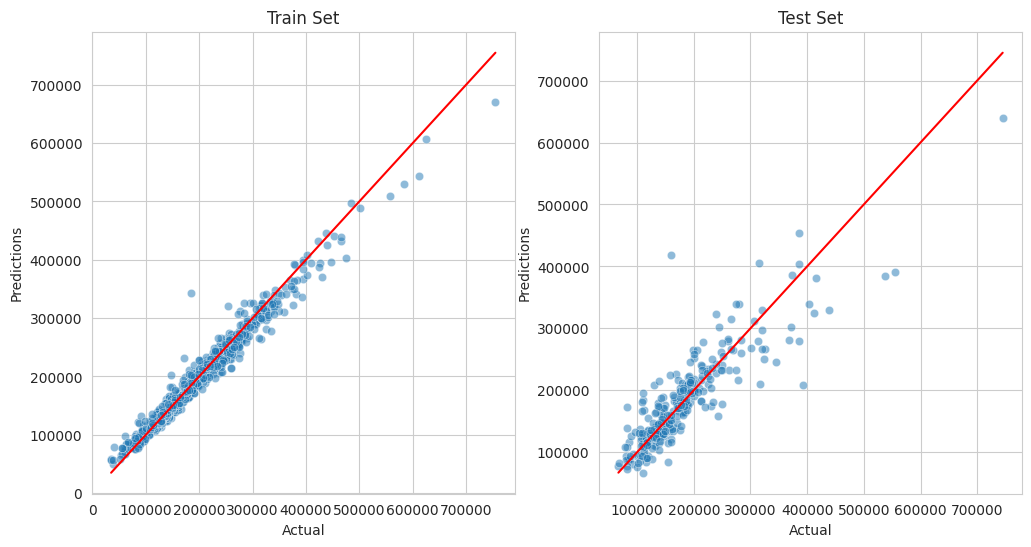

In [26]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

**Observations**

The performance metrics R2 are excellent for both the train set (0.97) and the test set (0.769), indicating no overfitting. The model meets the business criteria of an R2 score of 0.8 or higher.



### Regressor with PCA

In [33]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:9])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'pandas.core.frame.DataFrame'>


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


* The 17 components explain 100.0% of the data 



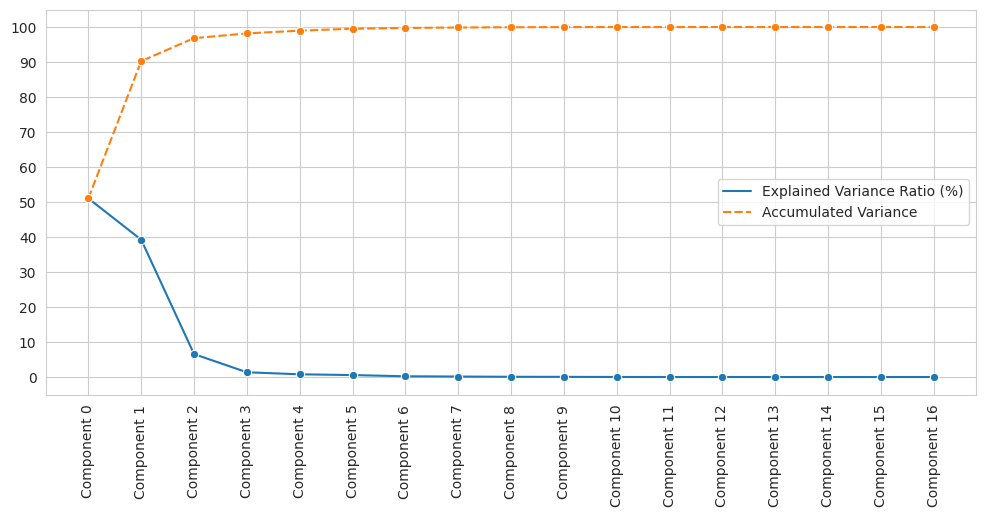

In [34]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 4 components explain 98.18% of the data 



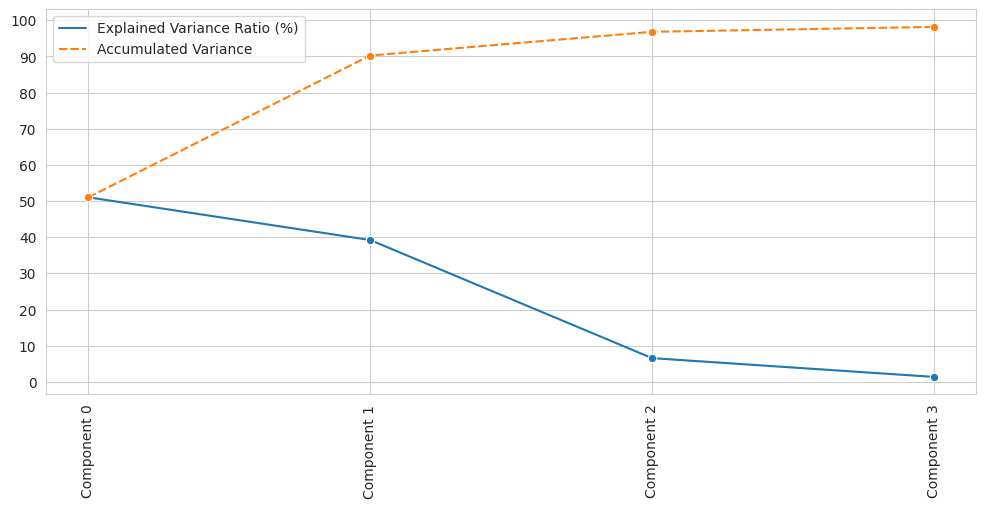

In [35]:
n_components = 4
pca_components_analysis(df_pca=df_pca, n_components=n_components)

### Rewrite Pipeline for Regression PCA Model

In [40]:
from sklearn.decomposition import PCA

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF','MasVnrArea'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),        
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # Principle Component Analysis
        ("PCA", PCA(n_components=4, random_state=0)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

In [41]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


In [42]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [43]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [52]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.605538,0.741681,0.792818,0.069491
5,GradientBoostingRegressor,0.564783,0.733667,0.796629,0.085427
3,ExtraTreesRegressor,0.521568,0.727438,0.795389,0.103432
6,XGBRegressor,0.509379,0.717266,0.7807,0.104166
0,LinearRegression,0.622689,0.684279,0.726477,0.038984
4,AdaBoostRegressor,0.465357,0.655323,0.765855,0.103727
1,DecisionTreeRegressor,0.290146,0.527238,0.623057,0.123258


In [53]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Model Evaluation 

* Train Set
R2 Score: 0.97
Mean Absolute Error: 8703.367
Mean Squared Error: 187086441.62
Root Mean Squared Error: 13677.955


* Test Set
R2 Score: 0.769
Mean Absolute Error: 25403.782
Mean Squared Error: 1596215574.465
Root Mean Squared Error: 39952.667




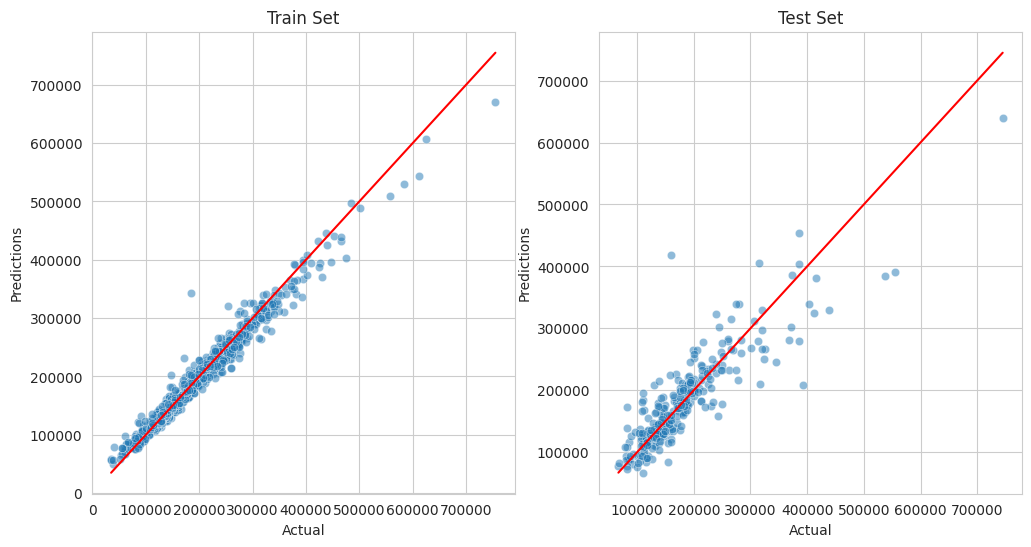

In [55]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

In [56]:
models_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor":{'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
                            }
}

In [57]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

---

In [58]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
1,RandomForestRegressor,0.605122,0.743729,0.79918,0.070892,None,None,1,2,50
49,RandomForestRegressor,0.605713,0.743555,0.802107,0.070666,15,None,1,2,50
0,RandomForestRegressor,0.605538,0.741681,0.792818,0.069491,None,None,1,2,100
2,RandomForestRegressor,0.604345,0.741251,0.794662,0.070355,None,None,1,2,140
48,RandomForestRegressor,0.603952,0.740776,0.793765,0.069931,15,None,1,2,100
...,...,...,...,...,...,...,...,...,...,...
34,RandomForestRegressor,0.615849,0.684444,0.750715,0.05658,4,None,50,50,50
44,RandomForestRegressor,0.617016,0.684421,0.752167,0.057772,4,50,50,2,140
47,RandomForestRegressor,0.617016,0.684421,0.752167,0.057772,4,50,50,50,140
32,RandomForestRegressor,0.617016,0.684421,0.752167,0.057772,4,None,50,2,140


The PCA analysis has not improved the performance of the modeling pipelin. Therefore we will use the pipeline which includes the feature selection step and the previously determined best hyperparameters.


## Setting and Saving the best ML pipeline

In [60]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF','MasVnrArea'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),        
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # Feature Selection
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

In [61]:
models_search = {        
    "RandomForestRegressor": RandomForestRegressor(random_state=0),    
}

params_search = {
    "RandomForestRegressor":{'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
    },    
}

In [62]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [63]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
2,RandomForestRegressor,0.688624,0.778326,0.821522,0.04741,None,None,1,2,140
50,RandomForestRegressor,0.69052,0.778261,0.821927,0.046647,15,None,1,2,140
48,RandomForestRegressor,0.690005,0.778257,0.823249,0.047149,15,None,1,2,100
0,RandomForestRegressor,0.684431,0.777866,0.821982,0.049057,None,None,1,2,100
1,RandomForestRegressor,0.672968,0.774769,0.82256,0.05287,None,None,1,2,50
...,...,...,...,...,...,...,...,...,...,...
30,RandomForestRegressor,0.574757,0.636292,0.68544,0.045129,4,None,50,2,100
32,RandomForestRegressor,0.575656,0.636145,0.685686,0.045457,4,None,50,2,140
35,RandomForestRegressor,0.575656,0.636145,0.685686,0.045457,4,None,50,50,140
47,RandomForestRegressor,0.575656,0.636145,0.685686,0.045457,4,50,50,50,140


In [64]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

In [65]:
# Defining the best pipeline

pipeline_regression = grid_search_pipelines[best_model].best_estimator_
pipeline_regression

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageYrBlt'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImp...
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GrLivArea', 'KitchenQual',
                                                     'LotArea', 'LotFrontage',
                                     

Model Evaluation 

* Train Set
R2 Score: 0.97
Mean Absolute Error: 8703.367
Mean Squared Error: 187086441.62
Root Mean Squared Error: 13677.955


* Test Set
R2 Score: 0.769
Mean Absolute Error: 25403.782
Mean Squared Error: 1596215574.465
Root Mean Squared Error: 39952.667




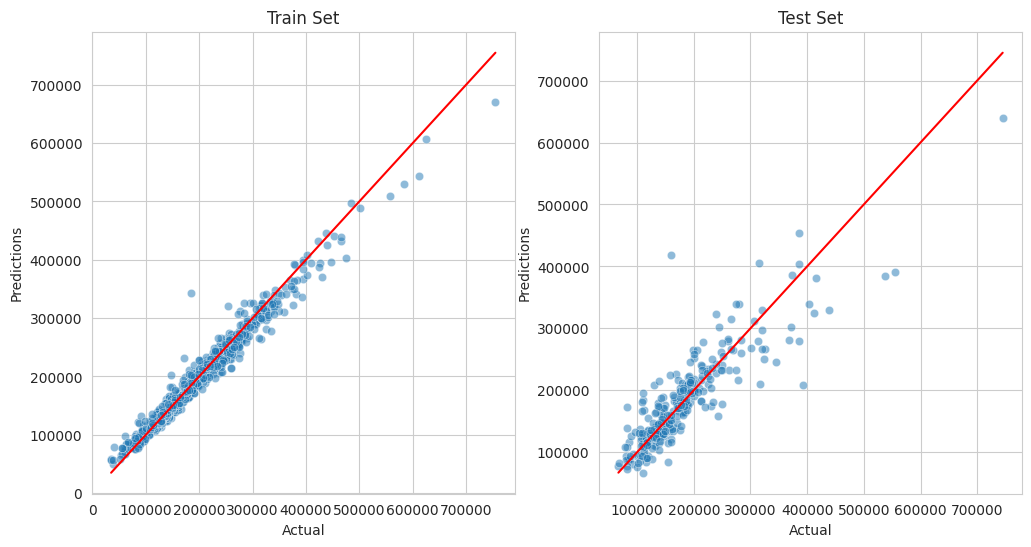

In [66]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_regression)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)

---

# Push files to Repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* Features importance plot

In [67]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)
    


### Train Set: Features and Target

In [68]:
X_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
618,1828,0.0,NaN,Av,48,NaN,1774,NaN,774,Unf,...,11694,90.0,452.0,108,5,9,1822,NaN,2007,2007
870,894,0.0,2.0,No,0,Unf,894,NaN,308,NaN,...,6600,60.0,0.0,0,5,5,894,NaN,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,NaN,432,Unf,...,13360,80.0,0.0,0,7,5,876,NaN,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,NaN,857,RFn,...,13265,NaN,148.0,59,5,8,1568,NaN,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,NaN,843,RFn,...,13704,118.0,150.0,81,5,7,1541,NaN,2001,2002


In [69]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [70]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [71]:

y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set: Features and Target

In [72]:
X_test.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
529,2515,0.0,4.0,No,1219,Rec,816,NaN,484,NaN,...,32668,NaN,NaN,0,3,6,2035,NaN,1957,1975
491,958,620.0,3.0,No,403,BLQ,238,NaN,240,Unf,...,9490,79.0,0.0,0,7,6,806,NaN,1941,1950
459,979,224.0,3.0,No,185,LwQ,524,NaN,352,Unf,...,7015,NaN,161.0,0,4,5,709,NaN,1950,1950
279,1156,866.0,4.0,No,392,BLQ,768,0.0,505,Fin,...,10005,83.0,299.0,117,5,7,1160,288.0,1977,1977
655,525,NaN,3.0,No,0,Unf,525,NaN,264,Unf,...,1680,21.0,381.0,0,5,6,525,NaN,1971,1971


In [73]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [74]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [75]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Modelling Pipeline

In [76]:
pipeline_regression

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageYrBlt'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImp...
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GrLivArea', 'KitchenQual',
                                                     'LotArea', 'LotFrontage',
                                     

In [77]:
joblib.dump(value=pipeline_regression, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v1/regression_pipeline.pkl']

### Feature Importance Plot

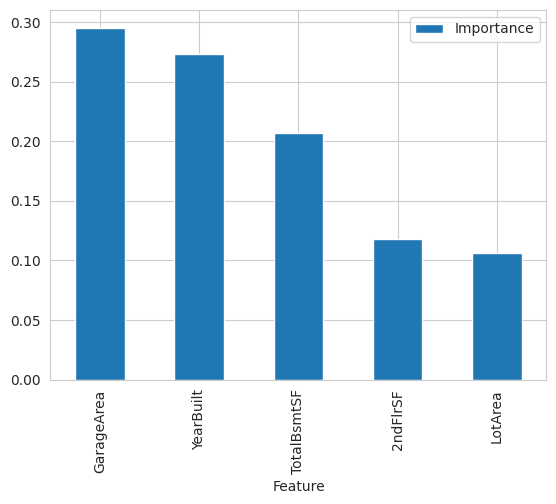

In [78]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

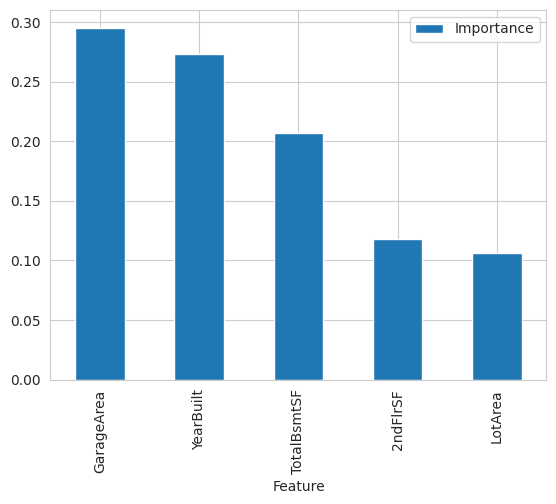

In [79]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

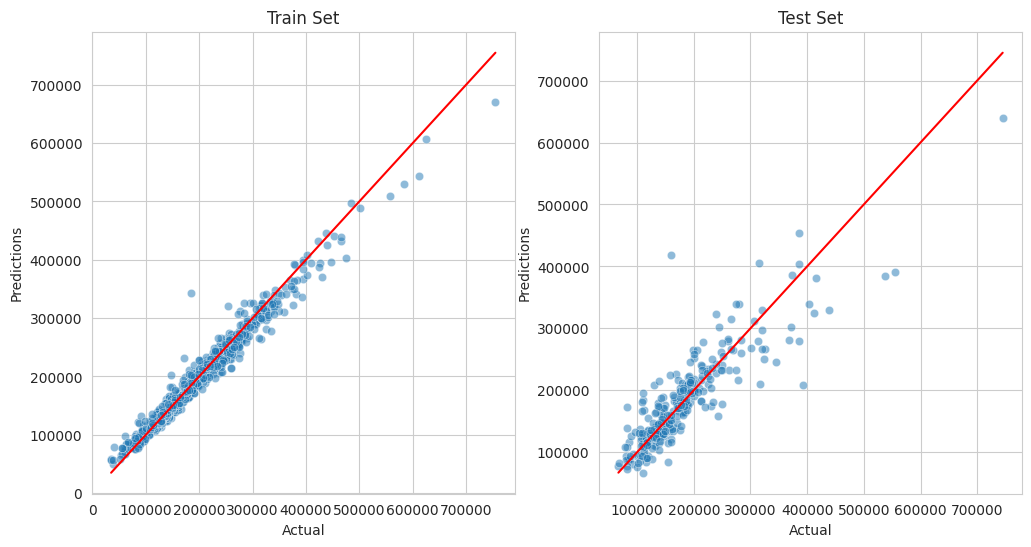

In [80]:
def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    # plt.show()
    plt.savefig(f'{file_path}/model_performance_evaluation.png', bbox_inches='tight')

regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)